In [30]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../my_implmnt")
import time
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from utils import dist_metic,feature_polynomial,prepareDatase
from cross_validation import cross_validation
from knn import KNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Random dataset (k degree polynomial) generation

In [31]:
#random data generantion
x = np.linspace(-1,1,100)
#get k degree polynomial
ExcessFeturdf = feature_polynomial(x,100)
y = np.sin(ExcessFeturdf)
df_ = ExcessFeturdf.copy()
df_["target"] = y.sum(axis=1)
df_.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x92,x93,x94,x95,x96,x97,x98,x99,x100,target
0,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,...,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,0.000000
1,-0.979798,0.960004,-0.940610,0.921608,-0.902989,0.884747,-0.866874,0.849361,-0.832202,0.815390,...,0.152954,-0.149864,0.146837,-0.143870,0.140964,-0.138116,0.135326,-0.132592,0.129913,-0.353861
2,-0.959596,0.920824,-0.883619,0.847918,-0.813658,0.780783,-0.749236,0.718964,-0.689915,0.662040,...,0.022497,-0.021588,0.020716,-0.019879,0.019076,-0.018305,0.017566,-0.016856,0.016175,-0.407241
3,-0.939394,0.882461,-0.828978,0.778737,-0.731541,0.687205,-0.645557,0.606432,-0.569678,0.535152,...,0.003177,-0.002984,0.002803,-0.002634,0.002474,-0.002324,0.002183,-0.002051,0.001927,-0.411345
4,-0.919192,0.844914,-0.776638,0.713879,-0.656192,0.603166,-0.554426,0.509624,-0.468442,0.430588,...,0.000430,-0.000395,0.000363,-0.000334,0.000307,-0.000282,0.000259,-0.000238,0.000219,-0.409218


In [32]:
my_knn = KNN(type_="Regression",\
             K=5,distance_metric= "no_numpy_euclidin")
runtm_ = {}
start, end = 0,0
for featrSet in range(1,len(ExcessFeturdf.columns)):
    start = time.time()
    my_knn.fit(ExcessFeturdf[ExcessFeturdf.columns[:featrSet]],\
              y[y.columns[:featrSet]])
    my_knn.predict(ExcessFeturdf[ExcessFeturdf.columns[:featrSet]])
    end = time.time()
    runtm_[featrSet] = end - start

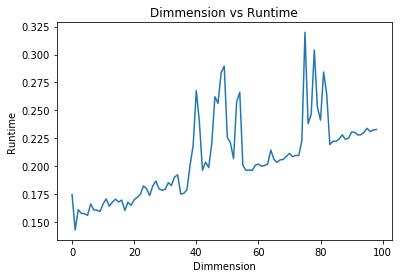

In [33]:
plt.plot(np.arange(len(ExcessFeturdf.columns)-1),list(runtm_.values()))
plt.xlabel("Dimmension")
plt.ylabel("Runtime")
plt.title("Dimmension vs Runtime");

#### Runtime is proportional to the number of features,i.e. the number of dimmension.

In [34]:
#for train instances
start_tm, end_tm = 0,0
runtm  = {}
for i in range(5,len(ExcessFeturdf)):
    start_tm = time.time()
    my_knn.fit(ExcessFeturdf.iloc[:i],y.iloc[:i])
    my_knn.predict(ExcessFeturdf.iloc[:i])
    end_tm = time.time()
    runtm[i] = end_tm - start_tm

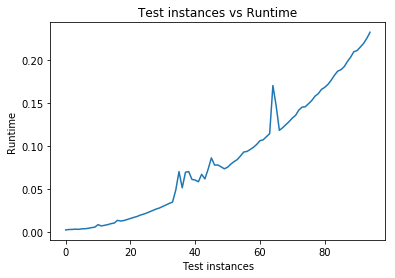

In [35]:
plt.plot(np.arange(len(ExcessFeturdf)-5),runtm.values())
plt.title("Test instances vs Runtime")
plt.xlabel("Test instances")
plt.ylabel("Runtime");

#### Runtime is proportional to the test instances that is the number of test points

Empirically we get the complexity of KNN to be proportional to the length of test instances and the dimensionality of the features, ie. ***O(dn)***, where d is the dimension size and n is the number of test instances. 
The theoretical complexity of Kmean is ***O(knd)*** , which justifies our result.

### KNN  for the real estate price prediction regression problem.

#### Cross validation to get the optimal k value

In [36]:
x_train, y_train, x_test, y_test = \
    prepareDatase().get_train_test("../dataset/realEstate.csv",False,0.7,True)

In [37]:
train, test = \
    prepareDatase().get_train_test("../dataset/realEstate.csv",False,0.7,False)

In [38]:
#my knn
my_knn = KNN(type_="Regression",K=5,distance_metric="Cosine-Similarity")
my_knn.fit(x_train,y_train)
y_hat = my_knn.predict(x_test.iloc[:40])
print ("RMSE error my model: ",my_knn.test_(y_hat,y_test.iloc[:40],eval_measure="RMSE"))

RMSE error my model:  43.6596795426


In [39]:
#sklearn knn
sk_knn = KNeighborsRegressor(n_neighbors=5)
sk_knn.fit(x_train,y_train)
y_hat = sk_knn.predict(x_test)
print ("RMSE error sklearn model: ",np.sqrt(mean_squared_error(y_hat,y_test)))

RMSE error sklearn model:  9.56396369713


In [40]:
crossVal = cross_validation(my_knn,[1,2,3,4,5,6,7,8,9,10],"KNN")
crossVal.optim_hyperparam(5,train);

In [41]:
res = crossVal.report_scores(train,test,5)
p = [[res[i][0]]+list(res[i][1]) for i in range(len(res))]
pd.DataFrame(p,columns=["K ","Train","Validation","Test"],\
             index=["fold-1","fold-2","fold-3","fold-4","fold-5"])

,K,Train,Validation,Test
fold-1,1,1499.973603,1512.434394,1499.973603
fold-2,1,1499.831550,1401.250451,1499.831550
fold-3,1,1499.831550,1563.232316,1499.831550
fold-4,1,1499.831550,1540.230964,1499.831550
fold-5,1,1499.831550,1482.277634,1499.831550


### Normalizing the data

In [43]:
x_train, y_train, x_test, y_test = \
    prepareDatase().get_train_test("../dataset/realEstate.csv",True,0.7,True)

In [44]:
train, test = \
    prepareDatase().get_train_test("../dataset/realEstate.csv",True,0.7,False)

In [45]:
my_knn = KNN(type_="Regression",K=5,distance_metric="Cosine-Similarity")
my_knn.fit(x_train,y_train)
y_hat = my_knn.predict(x_test.iloc[:40])
print ("RMSE error my KNN model: ",my_knn.test_(y_hat,y_test.iloc[:40],eval_measure="RMSE"))

RMSE error my KNN model:  0.497822156509


In [46]:
#SKlearn knn
sk_knn = KNeighborsRegressor(n_neighbors=5)
sk_knn.fit(x_train,y_train)
y_hat = sk_knn.predict(x_test)
print ("RMSE error for sklearn KNN model: ",np.sqrt(mean_squared_error(y_hat,y_test)))

RMSE error for sklearn KNN model:  0.0597467145894


In [47]:
crossVal = cross_validation(sk_knn,[1,2,3,4,5,6,7,8,9,10],"KNN")
crossVal.optim_hyperparam(5,train);

In [48]:
res = crossVal.report_scores(train,test,5)
p = [[res[i][0]]+list(res[i][1]) for i in range(len(res))]
pd.DataFrame(p,columns=["K ","Train","Validation","Test"],\
             index=["fold-1","fold-2","fold-3","fold-4","fold-5"])

,K,Train,Validation,Test
fold-1,5,0.004068,0.005050,0.004068
fold-2,7,0.004288,0.004484,0.004288
fold-3,7,0.004404,0.007648,0.004404
fold-4,6,0.004172,0.002674,0.004172
fold-5,10,0.004663,0.005862,0.004663


The features are not on the same scale. Which means feature at different scale are given different importatnce depending on there scale used. This model becomes biased to the feature that has a values that vary on the larger scale. This add bias to our model. While when scale all the features to the same scale the importance given to each of the featue becomes the same. The biases towards some features reduces on normalization.

### Below Single fold (train on first 80% data and last 20% as test data) and plot train, test error as a function of K 

In [49]:
k_values = np.arange(1,40)

In [50]:
#data = pd.DataFrame('realEstate.xlsx')
fold0 = cross_validation()._splt_datst(5,train)[0]  #get the fold-0
def plot_for_ks(test,train,k_lst):
    my_knn = KNeighborsRegressor()
    train_error= []
    for i in k_values:
        my_knn.n_neighbors = i
        my_knn.fit(train[train.columns[:-1]],train[[train.columns[-1]]])
        y_hat = my_knn.predict(test[test.columns[:-1]])
        train_error.append(mean_squared_error(y_hat,test[test.columns[-1]]))
    plt.scatter(np.arange(len(train_error)),train_error)
    plt.xlabel("K")

In [51]:
#split the fold0 into 80:20 train:test dataset
train_, test_ = prepareDatase().splitInto_test_train(fold0,0.8)

### Train error

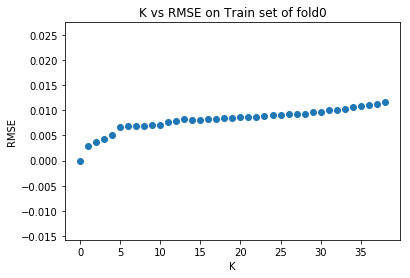

In [52]:
plot_for_ks(train_,train_,k_values)
plt.ylabel("RMSE");
plt.title("K vs RMSE on Train set of fold0");

The training curve increases monotonically. The reason is the  following: <br>
- Inially the model just returns the value corresponing y for the current datapoint, but when we increas the value of k we deviate from the corresponding y. We are taking the mean of all the k neareset points. This lead to wrong prediciton of corresponding y( may not be the case if all y's are same).

## Test Error

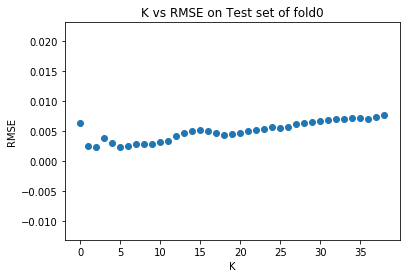

In [53]:
plot_for_ks(test_,train_,k_values)
plt.ylabel("RMSE")
plt.title("K vs RMSE on Test set of fold0");

The rmse of  test dataset first decreases and then increases. The reason is following: <br>
- The RMSE first decreases and then increases. The model is initially  ***overfitted*** and then at the minimum rmse it attains a model configuration where it can generalize well. After further increases in ***k*** the rmse monotonically increases which shows that the model is **underfitted** at higer value of ***k***.